### Heave and spice anomalies
Code to produce plots splitting temperature anomalies into spice (isopycnal temp/salinity gradient) and heave (movement of isopycnal) anomalies

Output is for upper Southern hemisphere, zonally averaged, but can be modified for use in other regions

In [9]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
from xhistogram.xarray import histogram
import pandas as pd
import cosima_cookbook as cc
from collections import OrderedDict


In [3]:
session = cc.database.create_session('/scratch/e14/cy8964/access-om2/archive/databases/1deg_jra55_ryf_experiments_1.db')

In [4]:
expt = '1deg_jra55_ryf_RCPcont'
temp_cont = cc.querying.getvar(expt, 'temp', session, ncfile = 'ocean.nc')
pot_rho_cont = cc.querying.getvar(expt,'pot_rho_2',session).groupby('time.year').mean(dim='time')
salt_cont = cc.querying.getvar(expt,'salt',session).groupby('time.year').mean(dim='time')
salt_cont = cc.querying.getvar(expt,'salt',session).groupby('time.year').mean(dim='time')
dzt_cont = cc.querying.getvar(expt,'dzt',session, ncfile = 'ocean_heat.nc').groupby('time.year').mean(dim='time')
area_t_cont= cc.querying.getvar(expt,'area_t',session, n=-1)

In [6]:
def decompose_temp_anom(ekey, year):
    expt = exptdict[ekey]['expt']
    pot_rho_warm = cc.querying.getvar(expt,'pot_rho_2',session).groupby('time.year').mean(dim='time')
    dzt_warm = cc.querying.getvar(expt,'dzt',session, ncfile = 'ocean_heat.nc').groupby('time.year').mean(dim='time')
    area_t_warm = cc.querying.getvar(expt,'area_t',session, n=-1)
    temp_warm = cc.querying.getvar(expt, 'temp', session, ncfile = 'ocean.nc')
    
    ds = xr.merge([pot_rho_warm, temp_warm.groupby('time.year').mean('time'), dzt_warm, area_t_warm])
    ds = ds.assign(volume = lambda ds : ds.dzt*ds.area_t)
    ds = ds.assign(y = lambda section : section.temp*0+section.yt_ocean)
    ds = ds.isel(year = year)
    ds = ds.assign(z = lambda section : section.temp*0+section.st_ocean)
    ybins = np.linspace(-90,90,60)
    rhobins = np.linspace(1032,1038,60)
    dVol = ds.volume   
    groupings = (histogram(ds.pot_rho_2, ds.y, bins = [rhobins, ybins], weights = ds.temp*dVol)/histogram( ds.pot_rho_2, ds.y,bins = [rhobins, ybins], weights = dVol))
    
    dsc = xr.merge([pot_rho_cont, temp_cont.groupby('time.year').mean('time'), dzt_cont, area_t_cont])
    dsc = dsc.assign(volume = lambda ds : ds.dzt*ds.area_t)
    dsc = dsc.assign(y = lambda section : section.temp*0+section.yt_ocean)
    dsc = dsc.isel(year = year)
    dVolc = dsc.volume
    groupings_cont = (histogram(dsc.pot_rho_2, dsc.y, bins = [rhobins, ybins], weights = dsc.temp*dVolc)/histogram( dsc.pot_rho_2, dsc.y,bins = [rhobins, ybins], weights = dVolc))

    depth_hist = (histogram(ds.pot_rho_2, ds.y, bins = [rhobins, ybins], weights = ds.z*dVol)/histogram( ds.pot_rho_2, ds.y,bins = [rhobins, ybins], weights = dVol))
    depth_hist = depth_hist.rename('depth_trans')
    spice_anom = groupings-groupings_cont
    spice_anom=spice_anom.rename('spice_anom')
    
    transform_hist = xr.merge([spice_anom, depth_hist])
    transform_hist = transform_hist.assign(y = lambda section : section.spice_anom*0+section.y_bin)
    transform_hist = transform_hist.assign(vol = lambda section : section.spice_anom*0+1)

    ybins = np.linspace(-90,90,60)
    zbins = np.linspace(-50,5050,60)
    dVol = transform_hist.vol
    hist = histogram(transform_hist.depth_trans, transform_hist.y, bins = [zbins, ybins], weights = transform_hist.spice_anom)/histogram(transform_hist.depth_trans, transform_hist.y, bins = [zbins, ybins], weights = dVol)
    hist = hist.interpolate_na(dim = 'depth_trans_bin', method="linear", use_coordinate='depth_trans_bin')
    hist = hist.interpolate_na(dim = 'y_bin', method="linear", use_coordinate='y_bin')

    hist = hist.interp(depth_trans_bin = temp_warm.st_ocean, y_bin = temp_warm.yt_ocean)
    
    return hist, spice_anom

In [37]:
def plot_decompose_temp_anom(ekey, hist, year):
    i = year
    fig, axes = plt.subplots(ncols=3, nrows=1, figsize = (18,6))
    plt.suptitle(ekey+'_'+str(2890+i), fontsize = 20)
    expt = exptdict[ekey]['expt']
    pot_rho_warm = cc.querying.getvar(expt,'pot_rho_2',session).groupby('time.year').mean(dim='time')
    temp_warm = cc.querying.getvar(expt, 'temp', session, ncfile = 'ocean.nc')

    (temp_warm - temp_cont).groupby('time.year').mean('time').mean('xt_ocean').isel(year = i).sel(yt_ocean = slice(-90,0),st_ocean = slice(0,1200)).plot(vmin =-lim[ekey], vmax = lim[ekey], yincrease = False, cmap = cm.cm.balance, ax=axes[0])
    pot_rho_warm_av = pot_rho_warm.mean('xt_ocean').isel(year = i).sel(yt_ocean = slice(-90,0),st_ocean = slice(0,1200))
    pot_rho_cont_av = pot_rho_cont.mean('xt_ocean').isel(year = i).sel(yt_ocean = slice(-90,0),st_ocean = slice(0,1200))
    pot_rho_cont_av_mean = pot_rho_cont.mean('xt_ocean').mean('year').sel(yt_ocean = slice(-90,0),st_ocean = slice(0,1200))
    densityof52deg = pot_rho_warm.mean('xt_ocean').isel(year = year).isel(st_ocean = 0).sel(yt_ocean = -52, method = 'nearest')
    
    clevel = np.arange(1034,1038,0.25)
    cs = axes[0].contour(pot_rho_warm_av.yt_ocean, pot_rho_warm_av.st_ocean, pot_rho_warm_av, levels=clevel, colors='k', linewidths=0.5)
    cs2 = axes[0].contour(pot_rho_cont_av.yt_ocean, pot_rho_cont_av.st_ocean, pot_rho_cont_av, levels=clevel, colors='k', linestyle = 'dotted', linewidths=0.25)
    cs3 = axes[0].contour(pot_rho_cont_av_mean.yt_ocean, pot_rho_cont_av_mean.st_ocean, pot_rho_cont_av_mean, levels=np.array([1035.9901]), colors='magenta', linewidths=1)
    cs4 = axes[0].contour(pot_rho_warm_av.yt_ocean, pot_rho_warm_av.st_ocean, pot_rho_warm_av, levels=np.array([densityof52deg.values]), colors='orange', linewidths=1)

    axes[0].set_ylim(1200,0)
    axes[0].set_xlim(-90,0)
    axes[0].clabel(cs, [1034.0,1035.0,1036.0,1037.0], fmt = '%1.0f')
    axes[0].set_title('temp anomaly')

    hist.plot(vmin = -lim[ekey], vmax = lim[ekey], cmap = cm.cm.balance, yincrease = False, ax = axes[1])
    clevel = np.arange(1034,1038,0.25)
    cs = axes[1].contour(pot_rho_warm_av.yt_ocean, pot_rho_warm_av.st_ocean, pot_rho_warm_av, levels=clevel, colors='k', linewidths=0.5)
    cs2 = axes[1].contour(pot_rho_cont_av.yt_ocean, pot_rho_cont_av.st_ocean, pot_rho_cont_av, levels=clevel, colors='k', linestyle = 'dotted', linewidths=0.25)
    cs3 = axes[1].contour(pot_rho_cont_av_mean.yt_ocean, pot_rho_cont_av_mean.st_ocean, pot_rho_cont_av_mean, levels=np.array([1035.9901]), colors='magenta', linewidths=1)
    cs4 = axes[1].contour(pot_rho_warm_av.yt_ocean, pot_rho_warm_av.st_ocean, pot_rho_warm_av, levels=np.array([densityof52deg.values]), colors='orange', linewidths=1)

    axes[1].set_ylim(1200,0)
    axes[1].set_xlim(-90,0)
    axes[1].clabel(cs, [1034.0,1035.0,1036.0,1037.0], fmt = '%1.0f')
    axes[1].set_title('spice anomaly')

    ((temp_warm - temp_cont).groupby('time.year').mean('time').mean('xt_ocean').isel(year = i)-hist).plot(yincrease = False, cmap = cm.cm.balance, vmin = -lim[ekey], vmax = lim[ekey], ax=axes[2])
    cs = axes[2].contour(pot_rho_warm_av.yt_ocean, pot_rho_warm_av.st_ocean, pot_rho_warm_av, levels=clevel, colors='k', linewidths=0.5)
    cs2 = axes[2].contour(pot_rho_cont_av.yt_ocean, pot_rho_cont_av.st_ocean, pot_rho_cont_av, levels=clevel, colors='k', linestyle = 'dotted', linewidths=0.25)
    cs3 = axes[2].contour(pot_rho_cont_av_mean.yt_ocean, pot_rho_cont_av_mean.st_ocean, pot_rho_cont_av_mean, levels=np.array([1035.9901]), colors='magenta', linewidths=1)
    cs4 = axes[2].contour(pot_rho_warm_av.yt_ocean, pot_rho_warm_av.st_ocean, pot_rho_warm_av, levels=np.array([densityof52deg.values]), colors='orange', linewidths=1)

    axes[2].set_ylim(1200,0)
    axes[2].set_xlim(-90,0)
    axes[2].clabel(cs, [1034.0,1035.0,1036.0,1037.0], fmt = '%1.0f')
    axes[2].set_title('heave anomaly')


In [34]:
exptdict = OrderedDict([
    ('Control',  {'expt':'1deg_jra55_ryf_RCPcont'}),
    ('Warming',  {'expt':'1deg_jra55_ryf_RCPwarmhumid'}),
    ('Warming x2',  {'expt':'1deg_jra55_ryf_RCPwarmhumid2x'}),
    ('Cooling',  {'expt':'1deg_jra55_ryf_RCPcoolhumid'}),
    ('Cooling x2',  {'expt':'1deg_jra55_ryf_RCPcoolhumid2x'}),
    ('Warming w/o humidity',  {'expt':'1deg_jra55_ryf_rcpwarm'}),
    ('Cooling w/o humidity',  {'expt':'1deg_jra55_ryf_rcpcool'}),
    ('Cooling w/o humidity2', {'expt':'1deg_jra55_ryf_RCPcool'}),
    ('Windup', {'expt':'1deg_jra55_ryf_red3DSK_C9'})

])
lim = {'Warming': 1.5,'Warming x2': 3,'Cooling':1.5,'Cooling x2':3}
label = {'Warming': 'Warming','Warming x2': 'Warming x2','Cooling':'Cooling','Cooling x2':'Cooling x2'}


In [40]:
hist, spice_anom = decompose_temp_anom('Cooling x2', 59)

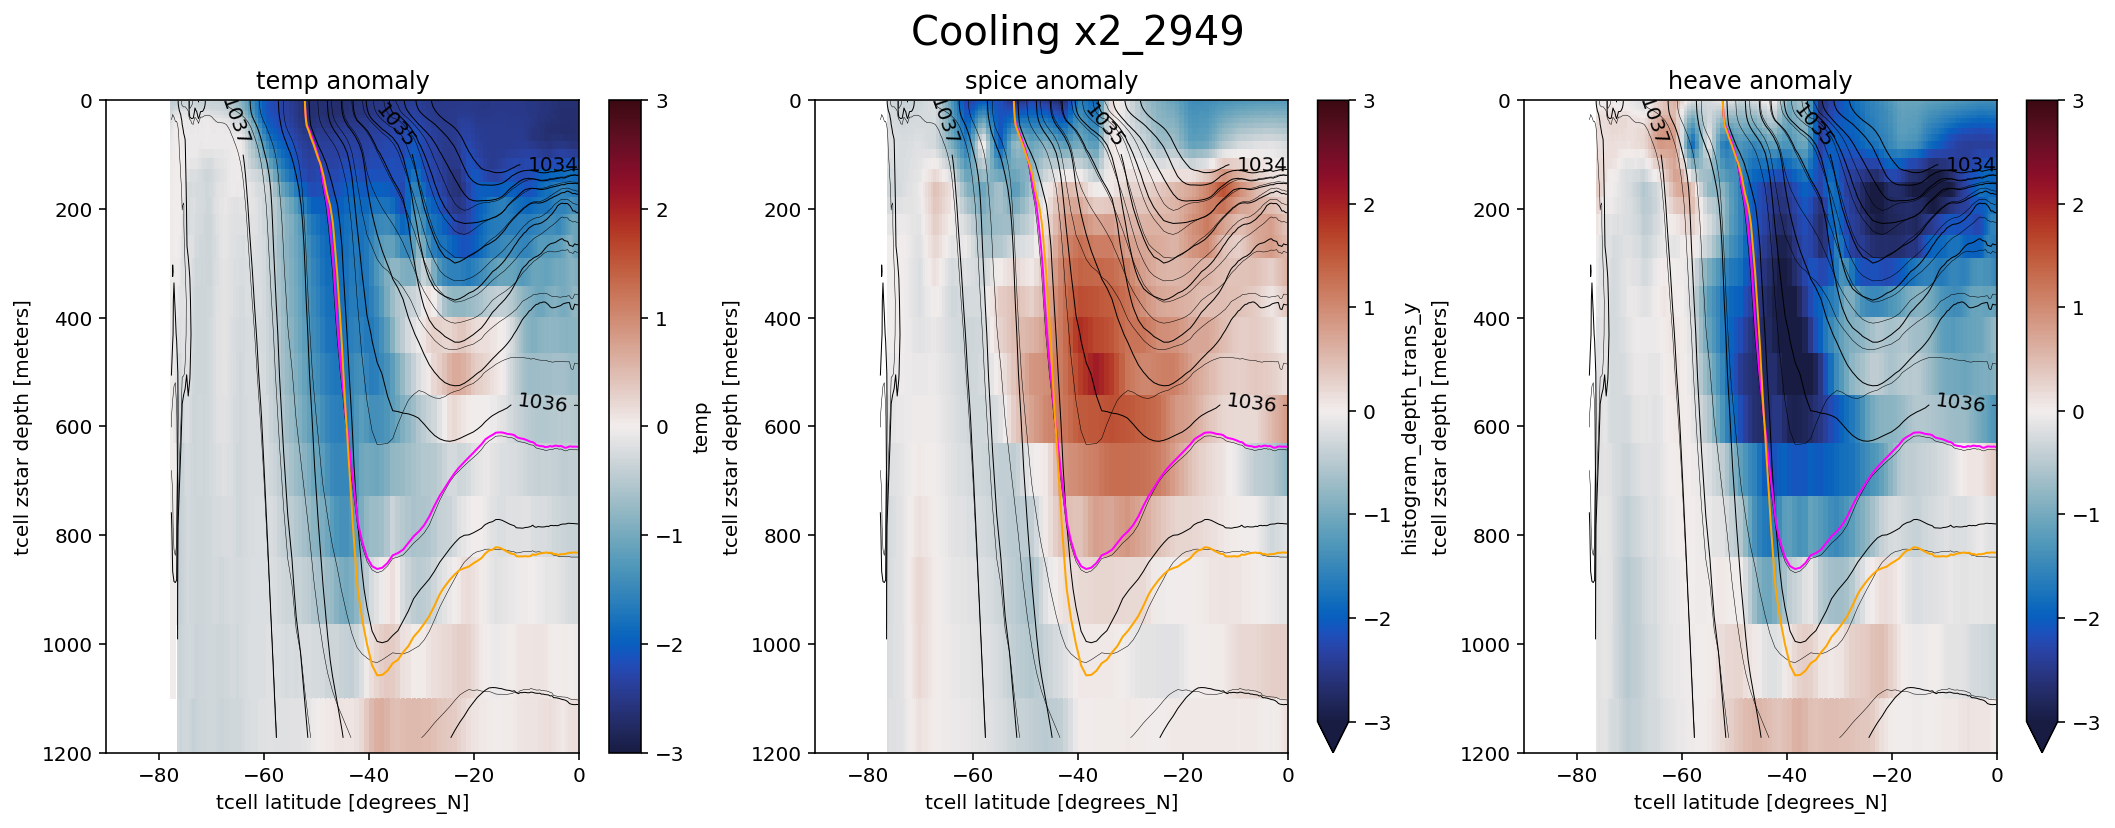

In [41]:
plot_decompose_temp_anom('Cooling x2', hist, 59)

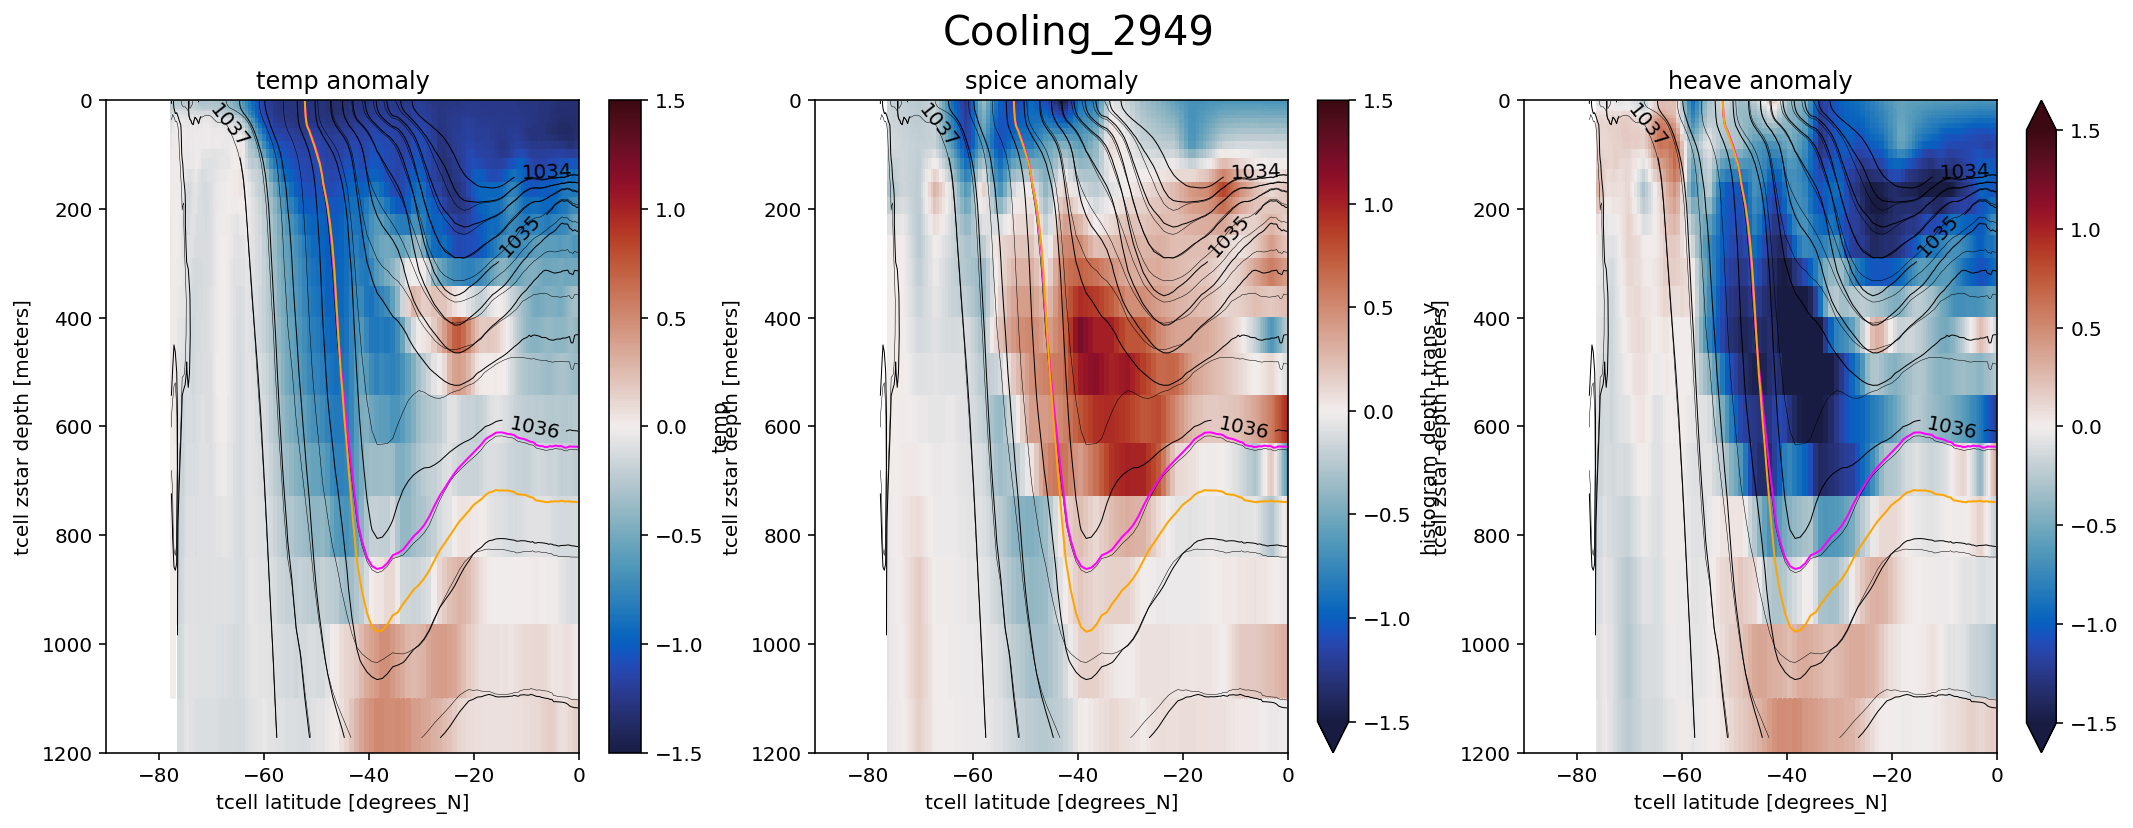

In [42]:
hist, spice_anom = decompose_temp_anom('Cooling', 59)
plot_decompose_temp_anom('Cooling', hist, 59)

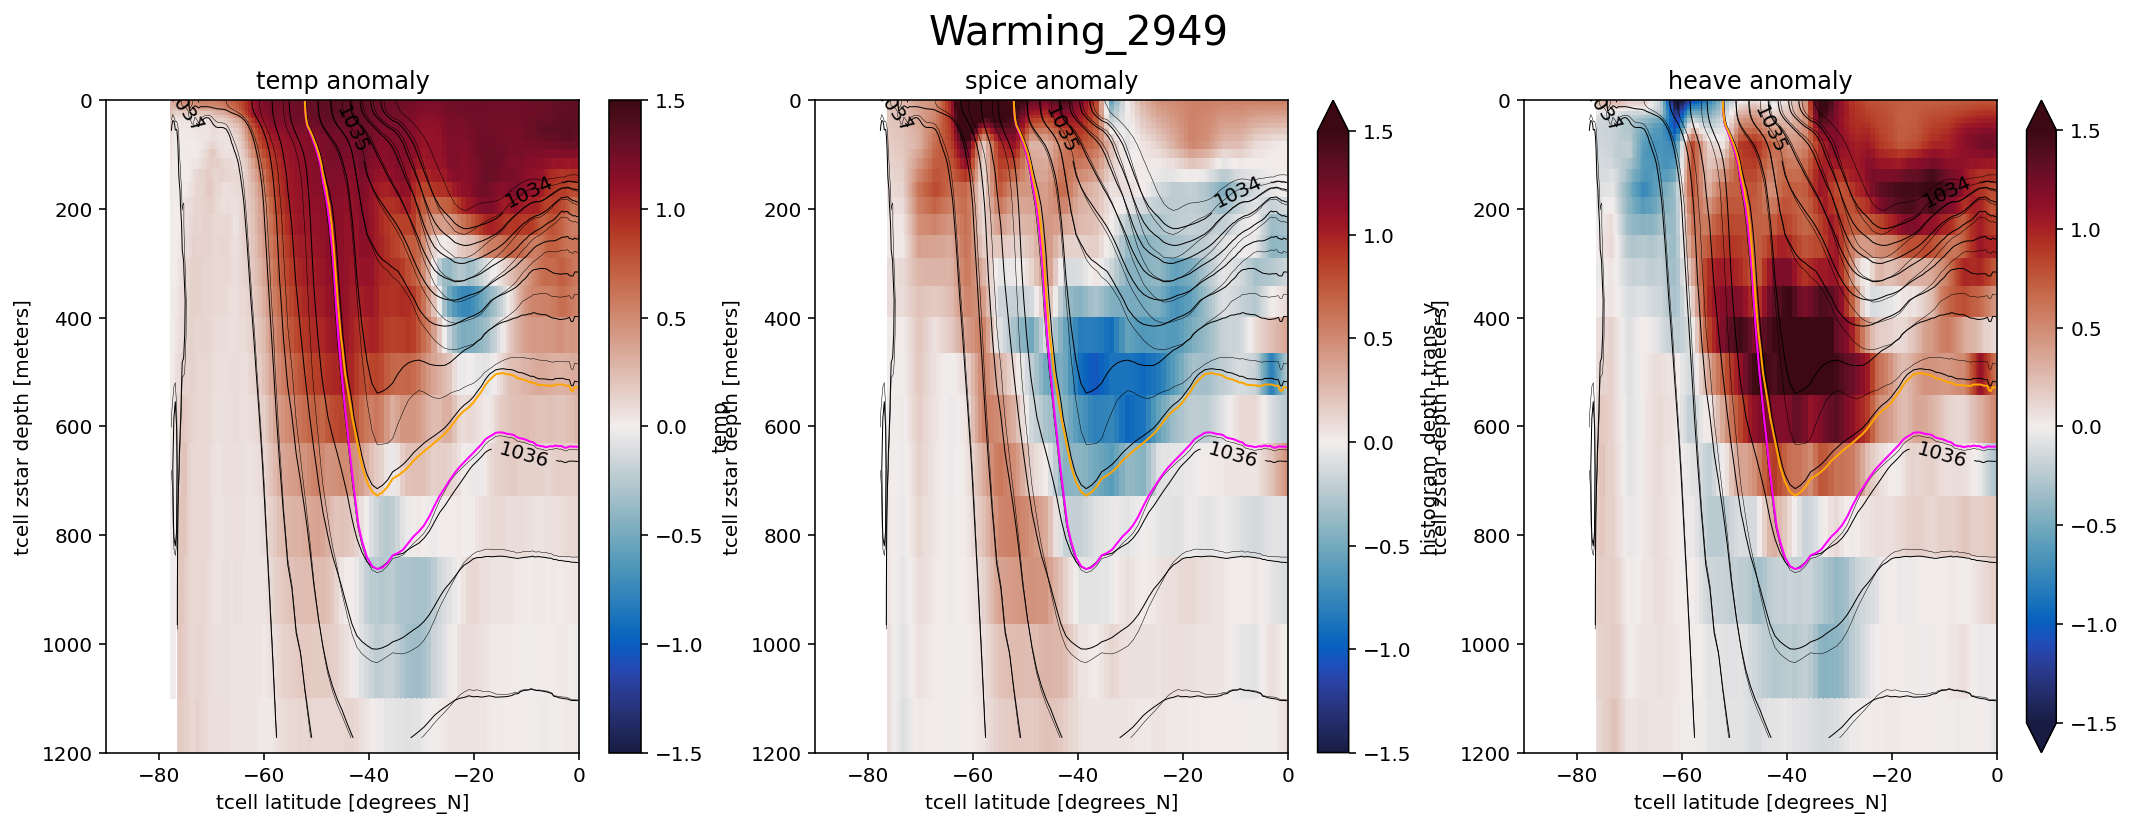

In [45]:
hist, spice_anom = decompose_temp_anom('Warming', 59)
plot_decompose_temp_anom('Warming', hist, 59)
plt.savefig('warming_decompose')

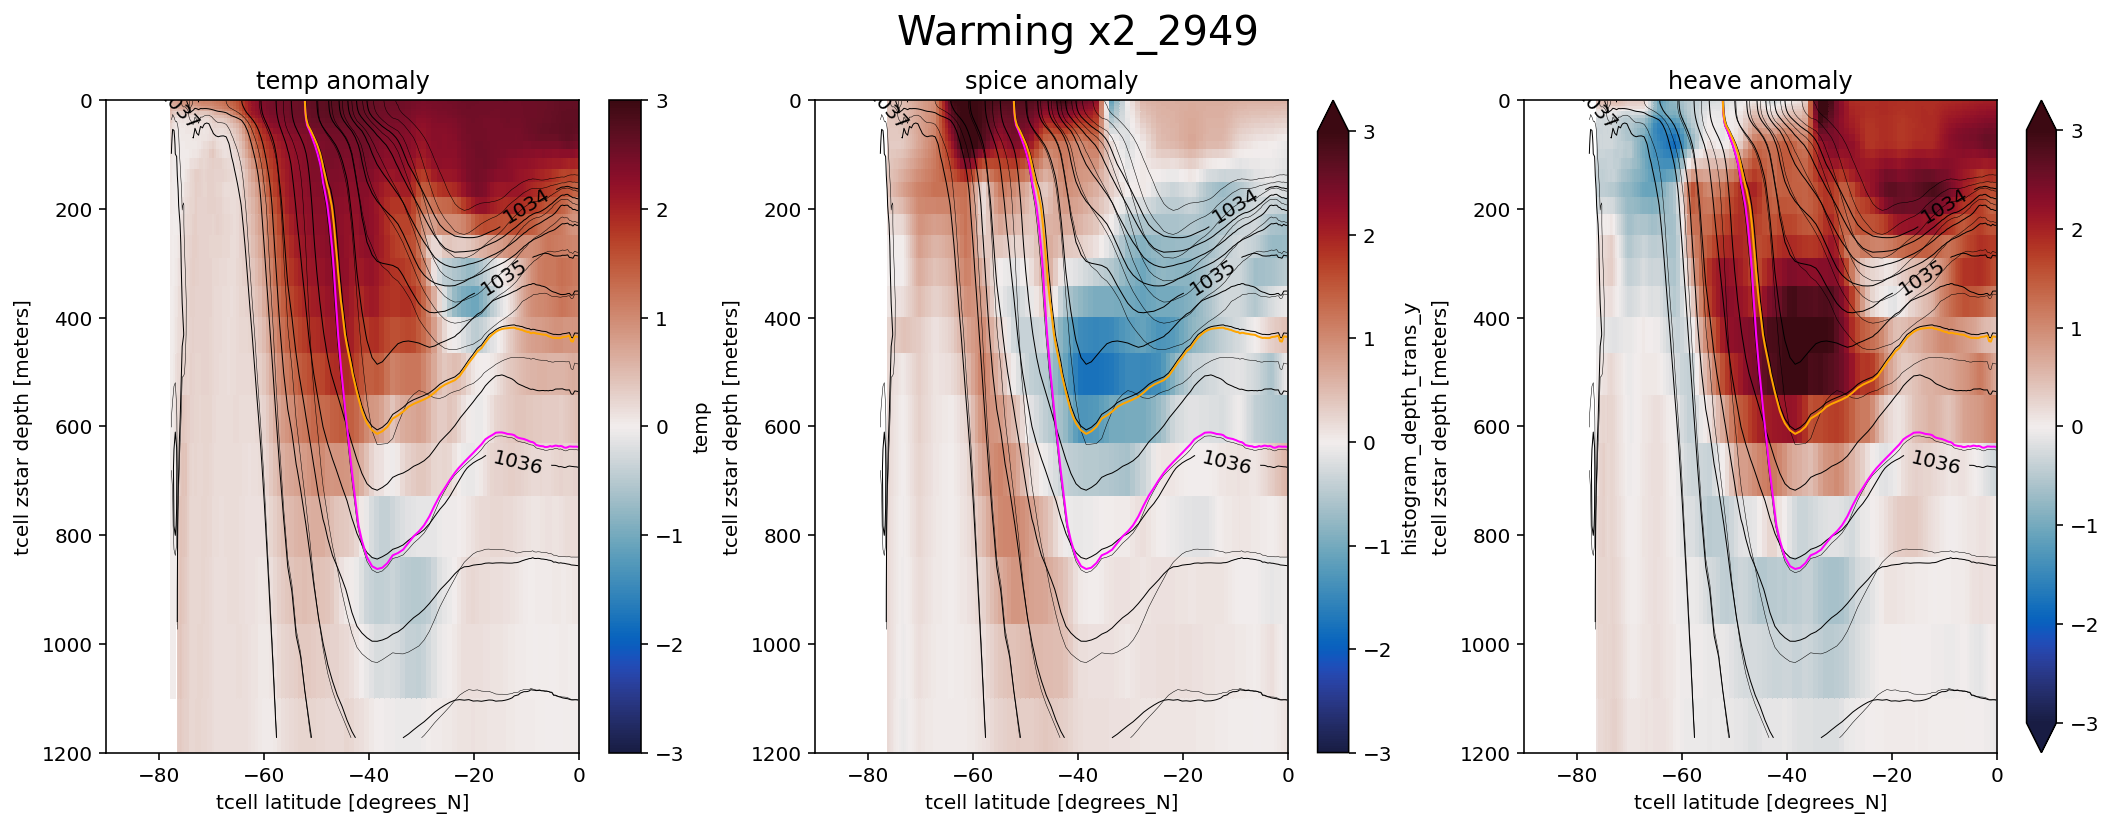

In [44]:
hist, spice_anom = decompose_temp_anom('Warming x2', 59)
plot_decompose_temp_anom('Warming x2', hist, 59)

# what about after 10 years?

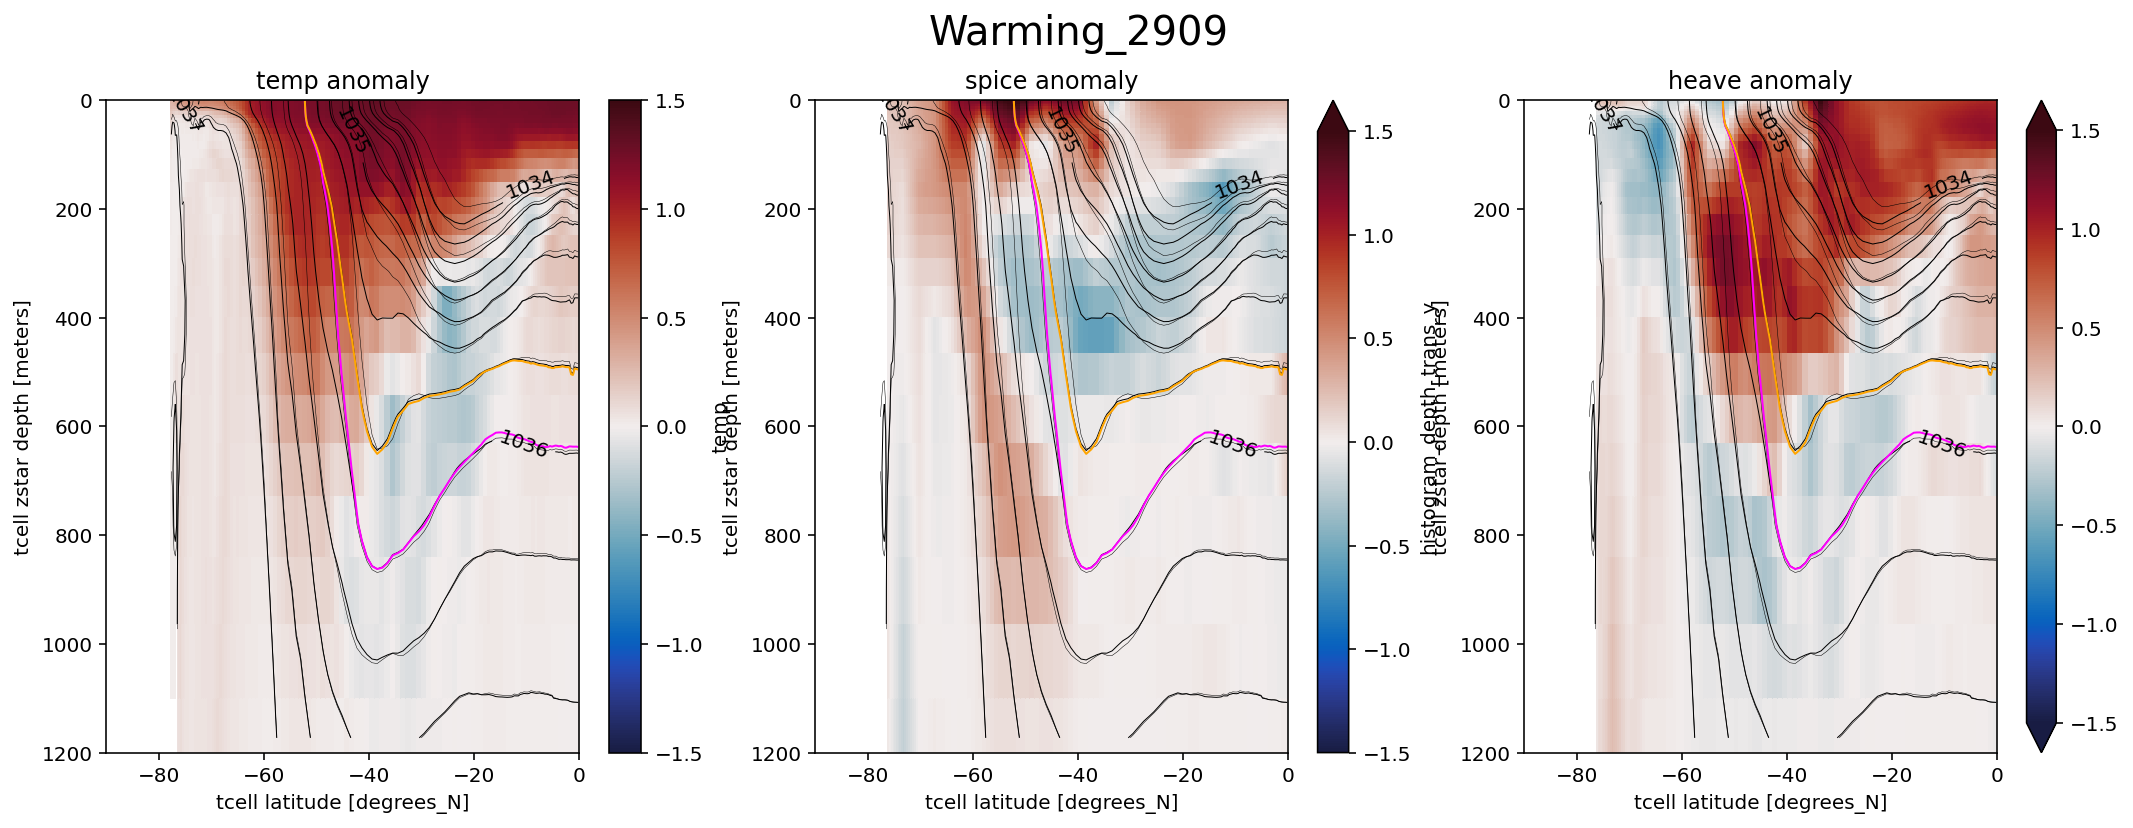

In [38]:
hist, spice_anom = decompose_temp_anom('Warming', 19)
plot_decompose_temp_anom('Warming', hist, 19)

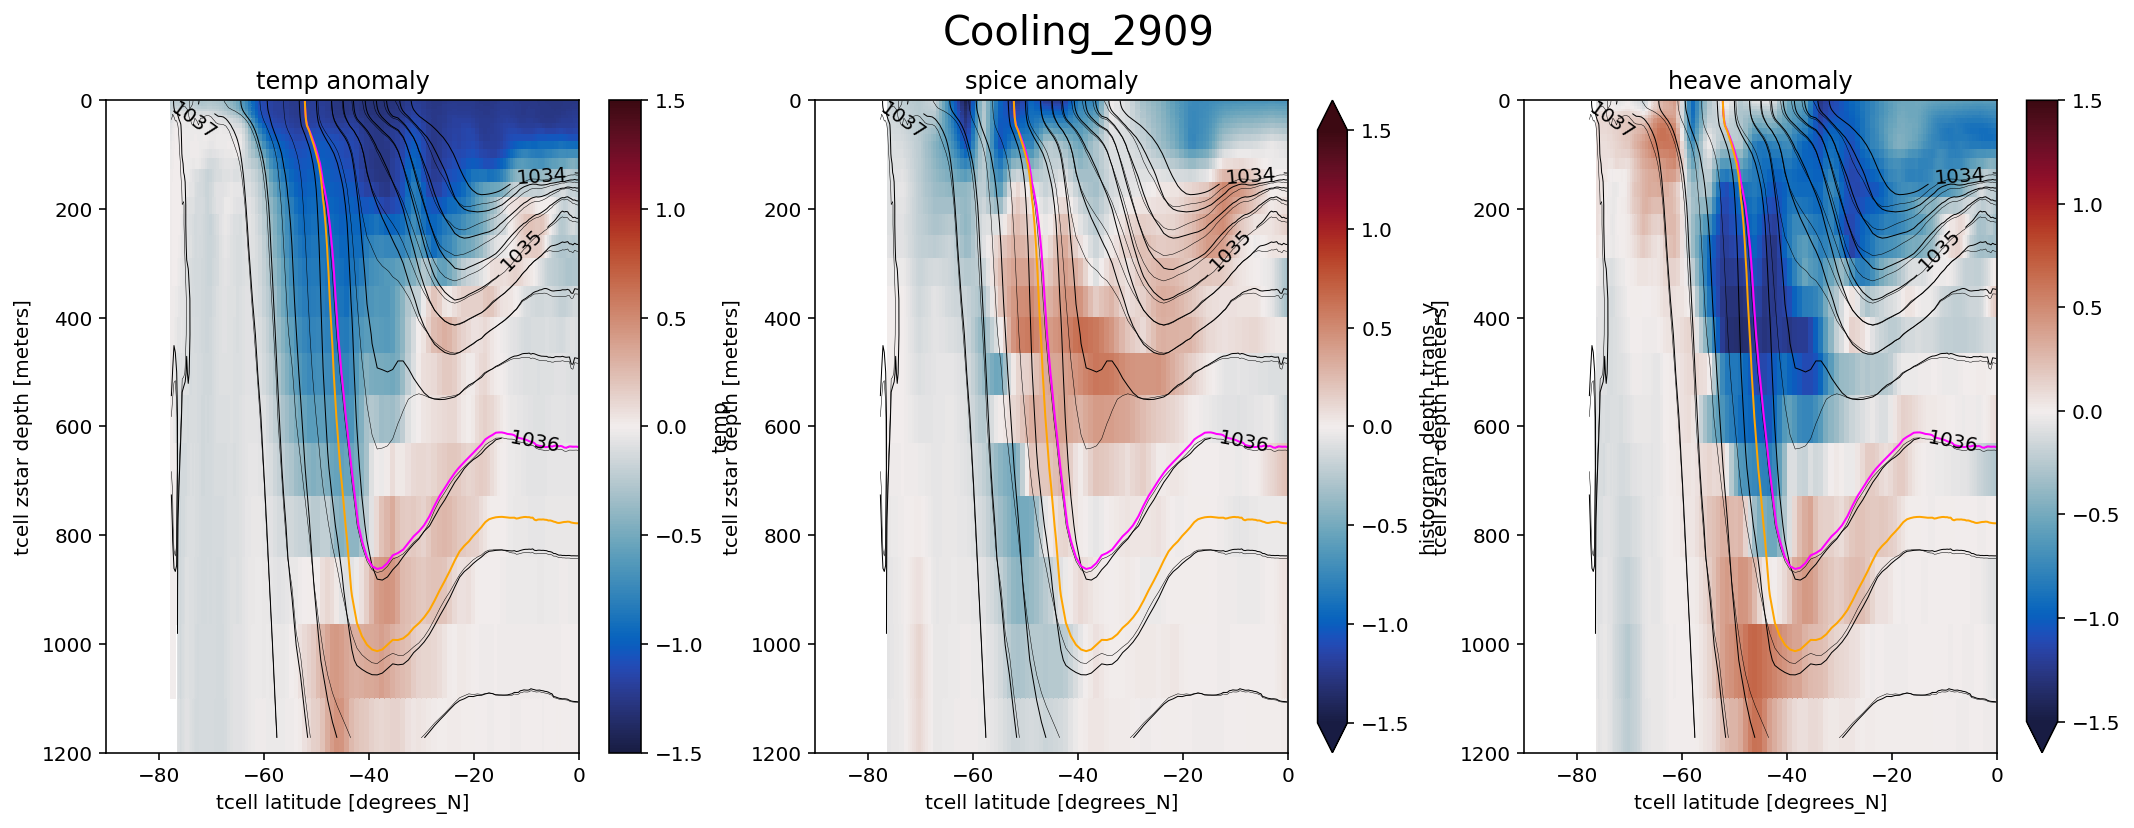

In [39]:
hist, spice_anom = decompose_temp_anom('Cooling', 19)
plot_decompose_temp_anom('Cooling', hist, 19)